In [68]:
# Imports
import torch
import torchvision
from torchvision.datasets import MNIST

In [69]:
# Download training dataset
dataset = MNIST(root='data/', download=True)

In [70]:
test_dataset = MNIST(root='data/', train=False)
len(test_dataset)

10000

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline

In [72]:
import torchvision.transforms as transforms

In [73]:
# MNIST dataset (images and labels)
dataset = MNIST(root='data/',
                train=True,
                transform=transforms.ToTensor())

In [74]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

In [75]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [80]:
import torch.nn as nn

input_size = 28*28
num_classes = 10
# Logistic regression model
model = nn.Linear(input_size, num_classes)

In [86]:
import torch.nn.functional as F

In [87]:
loss_fn = F.cross_entropy

In [88]:
# Loss for current batch of data
loss = loss_fn(outputs, labels)
print(loss)

tensor(2.3301, grad_fn=<NllLossBackward0>)


In [89]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results

    for epoch in range(epochs):

        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [90]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [91]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

model = MnistModel()

In [92]:
result0 = evaluate(model, val_loader)
result0

{'val_loss': 2.2976136207580566, 'val_acc': 0.08939873427152634}

In [93]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9385, val_acc: 0.6327
Epoch [1], val_loss: 1.6721, val_acc: 0.7331
Epoch [2], val_loss: 1.4724, val_acc: 0.7688
Epoch [3], val_loss: 1.3212, val_acc: 0.7865
Epoch [4], val_loss: 1.2045, val_acc: 0.7975


In [94]:
history2 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.1126, val_acc: 0.8099
Epoch [1], val_loss: 1.0388, val_acc: 0.8178
Epoch [2], val_loss: 0.9782, val_acc: 0.8238
Epoch [3], val_loss: 0.9277, val_acc: 0.8294
Epoch [4], val_loss: 0.8849, val_acc: 0.8341


In [95]:
history3 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.8482, val_acc: 0.8378
Epoch [1], val_loss: 0.8164, val_acc: 0.8411
Epoch [2], val_loss: 0.7885, val_acc: 0.8438
Epoch [3], val_loss: 0.7638, val_acc: 0.8470
Epoch [4], val_loss: 0.7418, val_acc: 0.8501


In [96]:
history4 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7220, val_acc: 0.8520
Epoch [1], val_loss: 0.7042, val_acc: 0.8541
Epoch [2], val_loss: 0.6880, val_acc: 0.8555
Epoch [3], val_loss: 0.6732, val_acc: 0.8565
Epoch [4], val_loss: 0.6596, val_acc: 0.8581


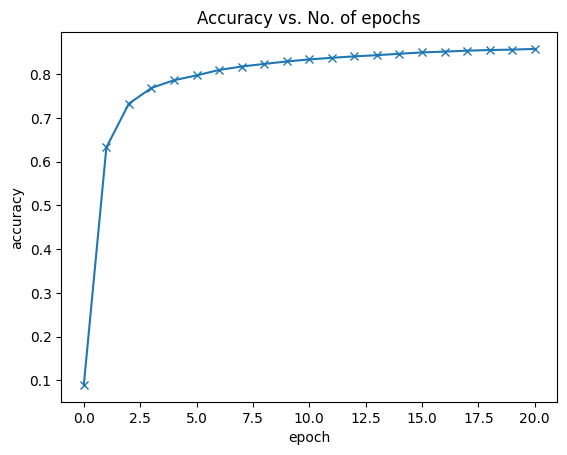

In [97]:
history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [98]:
# Define test dataset
test_dataset = MNIST(root='data/',
                     train=False,
                     transform=transforms.ToTensor())

In [99]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


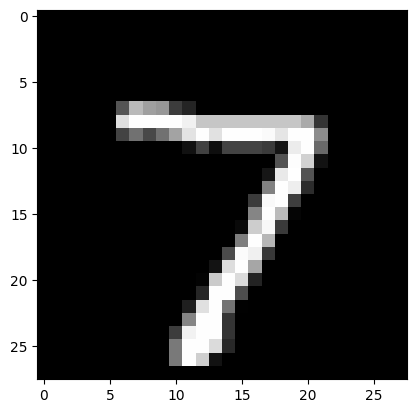

In [100]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 9


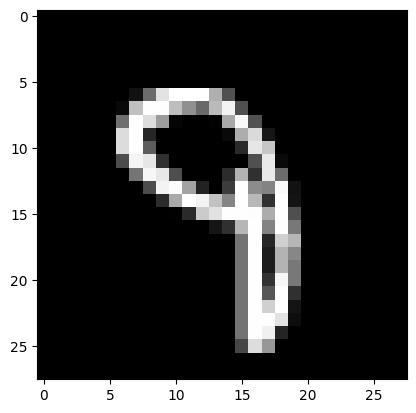

In [102]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [103]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_loss': 0.6427680850028992, 'val_acc': 0.8602539300918579}